FIRST STEPS

In [1]:
from utils import *

In [2]:

# Cargamos imagenes
train_images_b, train_labels_b = load_dataset_split_sobel_v4('data/original/balanced/train')
val_images_b, val_labels_b = load_dataset_split_sobel_v4('data/original/balanced/val')
test_images_b, test_labels_b = load_dataset_split_sobel_v4('data/original/balanced/test')

train_images_f, train_labels_f = load_dataset_split_sobel_v4('data/augmented/FracAtlas/train')
val_images_f, val_labels_f = load_dataset_split_sobel_v4('data/augmented/FracAtlas/val')
test_images_f, test_labels_f = load_dataset_split_sobel_v4('data/augmented/FracAtlas/test')

train_images = np.concatenate([train_images_b, train_images_f])
train_labels = np.concatenate([train_labels_b, train_labels_f])
test_images = np.concatenate([test_images_b, test_images_f])
test_labels = np.concatenate([test_labels_b, test_labels_f])
val_images = np.concatenate([val_images_b, val_images_f])
val_labels = np.concatenate([val_labels_b, val_labels_f])





In [3]:
# Creamos Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [4]:
#Calculamos pesos en función del conteo
class_weights = compute_class_weight('balanced', 
                                   classes=np.unique(train_labels), 
                                   y=train_labels)
class_weight = {0: class_weights[0], 1: class_weights[1]}


In [5]:
from tensorflow.keras import regularizers
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation="relu", input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(256, (3, 3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation="relu",kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
])

In [6]:

model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy", tf.keras.metrics.Precision(), 
                       tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6
)

history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    class_weight=class_weight,
    callbacks=[early_stopping, reduce_lr]
)



Epoch 1/100


320/320 [==============================] - 254s 782ms/step - loss: 3.5383 - accuracy: 0.8551 - precision: 0.8847 - recall: 0.8411 - auc: 0.8952 - val_loss: 8.3196 - val_accuracy: 0.4940 - val_precision: 1.0000 - val_recall: 0.0100 - val_auc: 0.5117 - lr: 0.0010
Epoch 2/100
320/320 [==============================] - 246s 769ms/step - loss: 1.1072 - accuracy: 0.8577 - precision: 0.9074 - recall: 0.8199 - auc: 0.9289 - val_loss: 3.2927 - val_accuracy: 0.5179 - val_precision: 0.8542 - val_recall: 0.0686 - val_auc: 0.5895 - lr: 0.0010
Epoch 3/100
320/320 [==============================] - 248s 774ms/step - loss: 0.8474 - accuracy: 0.8646 - precision: 0.9015 - recall: 0.8409 - auc: 0.9295 - val_loss: 1.3721 - val_accuracy: 0.5889 - val_precision: 0.8343 - val_recall: 0.2441 - val_auc: 0.6250 - lr: 0.0010
Epoch 4/100
320/320 [==============================] - 250s 781ms/step - loss: 0.7262 - accuracy: 0.8654 - precision: 0.9218 - recall: 0.8201 - auc: 0.9307 - val_loss: 2.6803 

KeyboardInterrupt: 

In [ ]:
test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test AUC: {test_auc}")

37/37 [==============================] - 8s 209ms/step - loss: 0.8498 - accuracy: 0.6361 - precision: 0.7649 - recall: 0.4698 - auc: 0.7245
Test Accuracy: 0.636130154132843
Test Precision: 0.7648578882217407
Test Recall: 0.46984127163887024
Test AUC: 0.7245205640792847


37/37 [==============================] - 8s 197ms/step


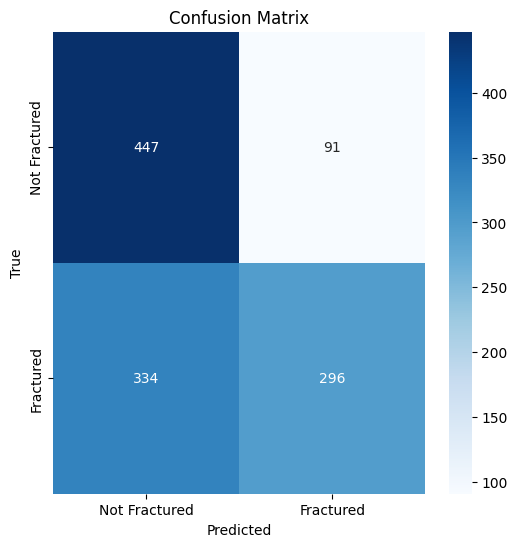

In [ ]:
plot_conf_matrix(model, test_images, test_labels)

In [ ]:
filename = 'binary_model_v4_augmented_sobel_v4.pkl'
create_pkl(filename, model)

In [ ]:
model.save('binary_model_v4_augmented_sobel_v4.keras') 

37/37 [==============================] - 8s 202ms/step


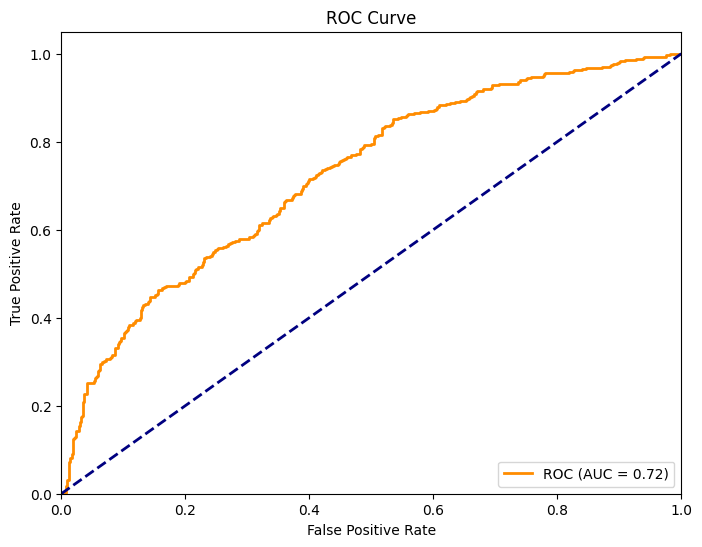

In [ ]:
plot_roc_curve(model, test_images, test_labels)

37/37 [==============================] - 8s 208ms/step


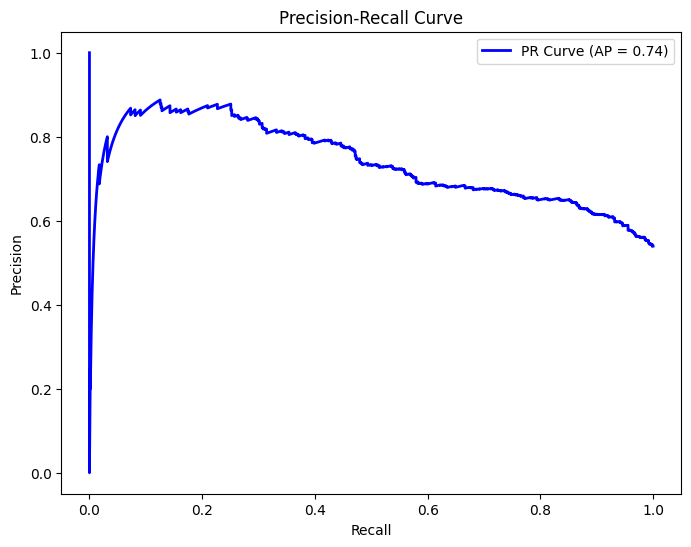

In [ ]:
plot_pr_curve(model, test_images, test_labels)

37/37 [==============================] - 7s 194ms/step


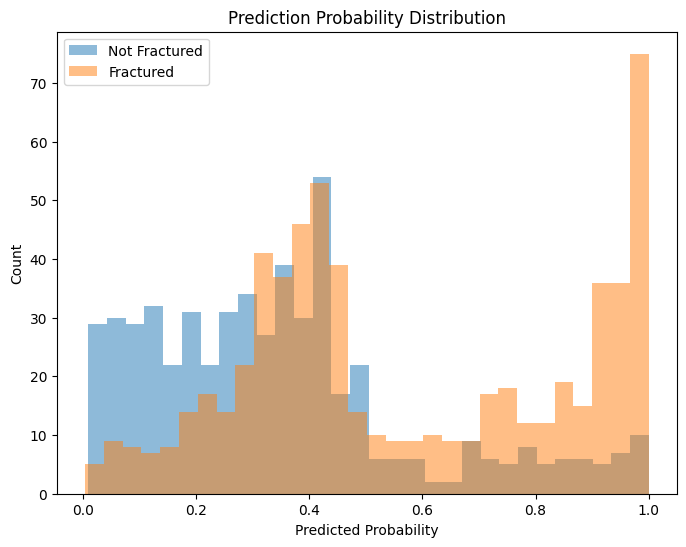

In [ ]:
p_proba_dist(model, test_images, test_labels)

37/37 [==============================] - 7s 187ms/step


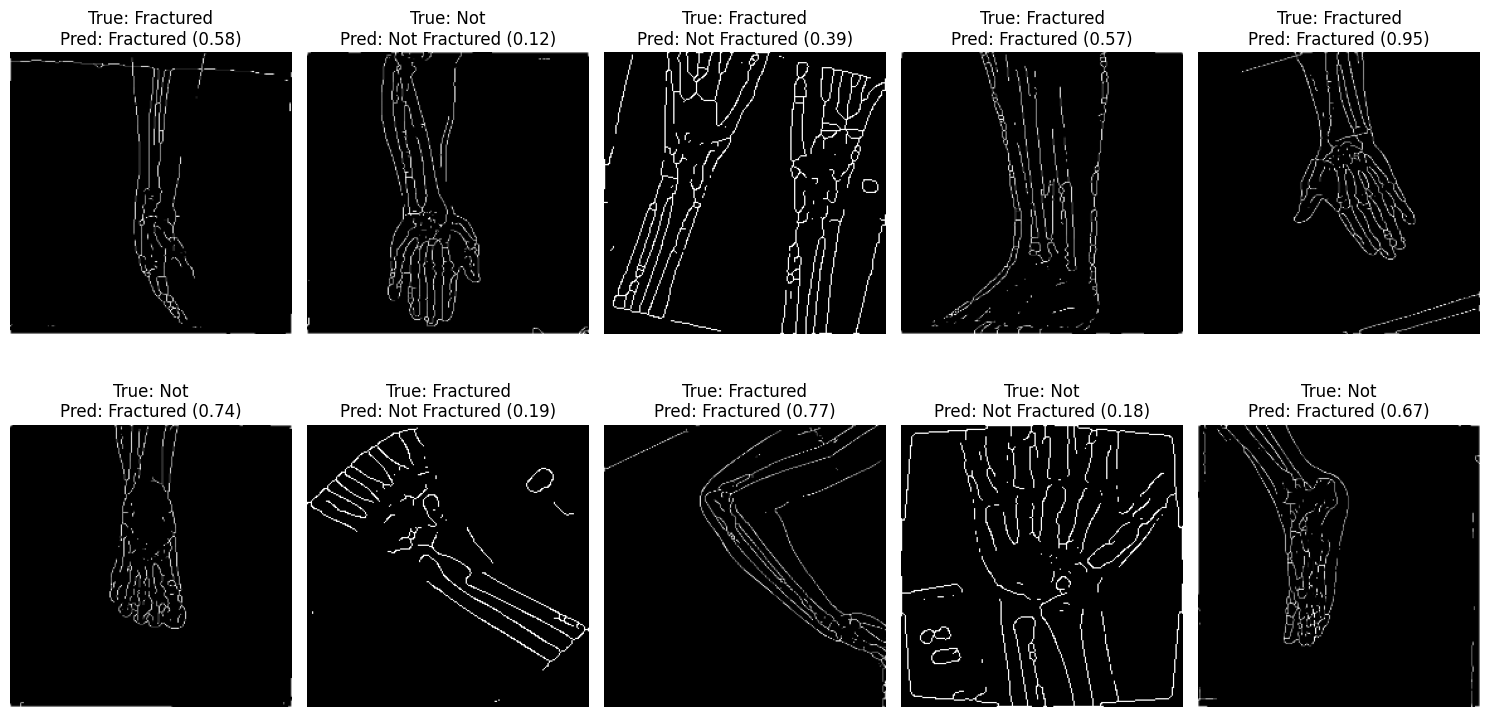

In [ ]:
show_ten_samples(model, test_images, test_labels)

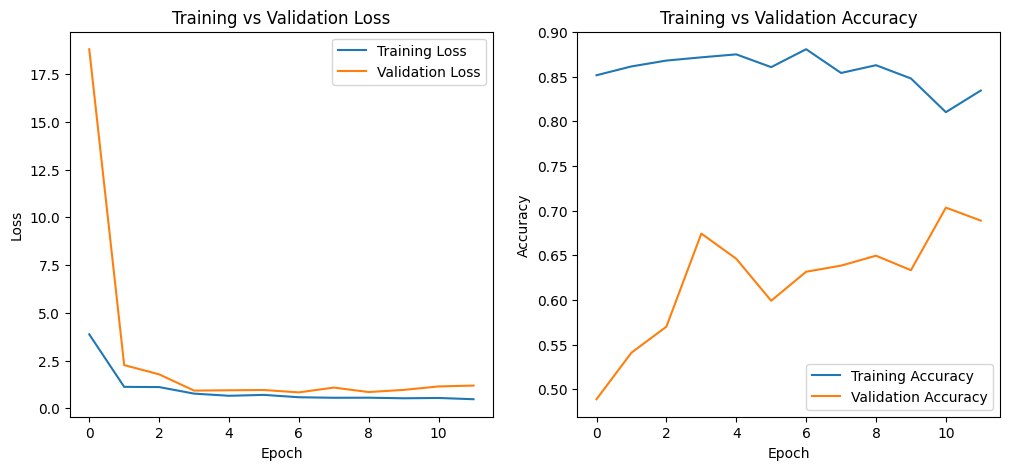

In [ ]:
loss_accu_train(history)

Revisando las métricas, vamos a ajustar 8 epochs el modelo.